## Step 1: Reading & displaying the image
- Use matplotlib to read the file “quarters_dimes_pennies.png” 
- Convert it to grayscale and display both the original and grayscale images

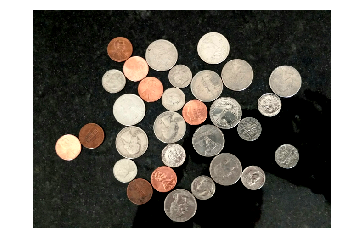

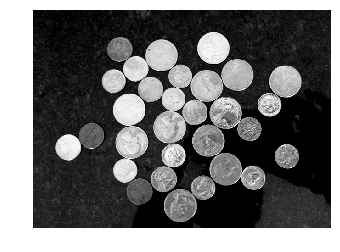

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
%matplotlib inline

def my_imshow(im, title=None, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    plt.figure()
    plt.imshow(im, interpolation='none', **kwargs)
    if title:
        plt.title(title)
    plt.axis('off')

im = plt.imread('images/quarters_dimes_pennies.png')
gray_im = color.rgb2gray(im)

my_imshow(im)
my_imshow(gray_im)

## Step 2: Thresholding
- Create a binary mask by thresholding the grayscale image
- Use a histogram and some guesswork to determine the threshold or use one of the threshold functions in skimage.filters. A good choice is Ostu’s method.

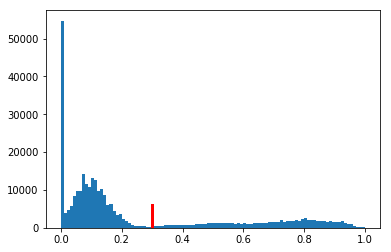

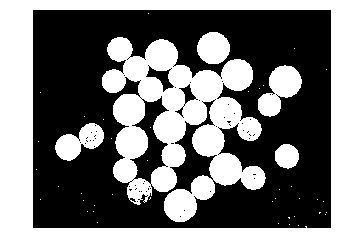

In [17]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(gray_im, nbins=5)

thresholded = gray_im > thresh

plt.figure()
plt.hist(gray_im.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');

my_imshow(thresholded)

## Step 3: Cleaning up the mask
- Your mask will inevitably have some noise.
- Use morphology operators to clean up the mask.
- It doesn’t have to be 100% perfect, but you should be able to get rid of the specks.

(-0.5, 648.5, 474.5, -0.5)

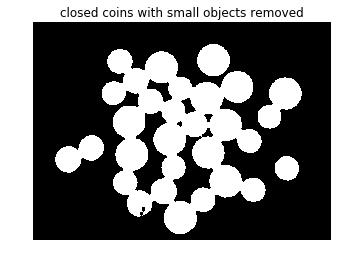

In [18]:
from skimage import morphology
from skimage.morphology import disk

no_small = morphology.remove_small_objects(thresholded, min_size=150)

coins = morphology.binary_closing(no_small,disk(3)) 
plt.figure()
plt.imshow(coins, cmap='gray', interpolation='none')
plt.title('closed coins with small objects removed')
plt.axis('off')

## Step 4: Masking
- It will be convenient to set the background to black.
- Use the coin mask that you created to set the backgrounds of both the original color image, and the grayscale image to zero. 
- You should be able to see the coins in color, but the counter (and the reflections in the counter) should be black. 
- Set the background of the grayscale image to zero as well.
- From now on, we don’t have to worry about the background affecting our results because we’ve masked it out.

(-0.5, 648.5, 474.5, -0.5)

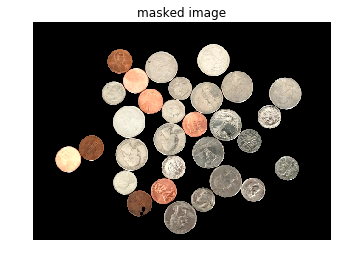

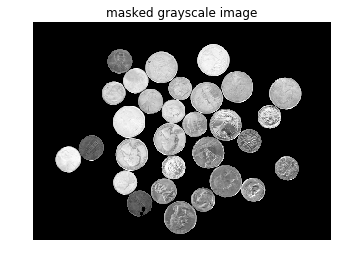

In [19]:
im[coins==False] = 0
gray_im[coins==False] = 0


plt.figure()
plt.imshow(im, cmap='gray', interpolation='none')
plt.title('masked image')
plt.axis('off')

plt.figure()
plt.imshow(gray_im, cmap='gray', interpolation='none')
plt.title('masked grayscale image')
plt.axis('off')

## Step 5: Watershed Segmentation
- Now we want to distinguish the coins from each other.
- Use the watershed-based segmentation to create a label image for the coins.
- Print the number of coins in the image.

distance transform: (475, 649) float64
number of coins: 85


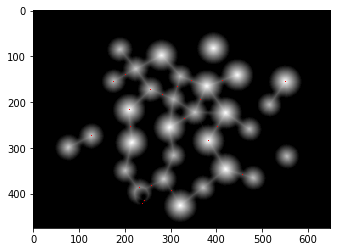

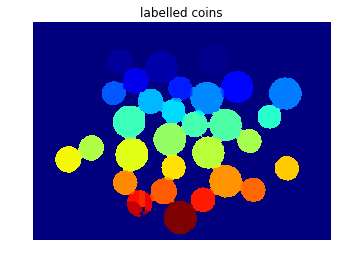

In [20]:
from scipy import ndimage as ndi
from matplotlib.colors import ListedColormap

distance_im = ndi.distance_transform_edt(coins)
print('distance transform:', distance_im.shape, distance_im.dtype)

from skimage import feature, measure

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


peaks_im = feature.peak_local_max(distance_im, indices=False)

plt.figure()
imshow_overlay(distance_im, peaks_im, alpha=1, cmap='gray')

markers_im = measure.label(peaks_im)
labelled_coins = morphology.watershed(-distance_im, markers_im, mask=coins) 
num_coins = len(np.unique(labelled_coins))-1  # subtract 1 b/c background is labelled 0
print('number of coins: %i' % num_coins)

my_imshow(labelled_coins, 'labelled coins', cmap='jet')

## Step 6: Quantifying & displaying the object sizes
- Look up the documentation for scikit-image function regionprops online. 
- Use this function with the labelled coins image to compute the area of each coin and the location of each coin’s center (the center is called the “centroid”). 
- Display the image and use matplotlib’s text function to write the area of each coin at its center.

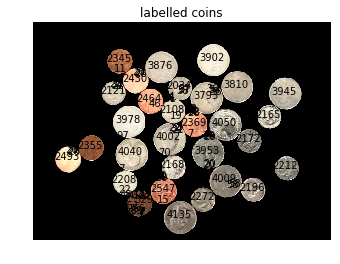

In [21]:
my_imshow(im, 'labelled coins', cmap='jet')

properties = measure.regionprops(labelled_coins)
coin_areas = [int(prop.area) for prop in properties]
coin_centroids = [prop.centroid for prop in properties]

for lab in range(len(coin_areas)):
    plt.text(coin_centroids[lab][1]-30,coin_centroids[lab][0],coin_areas[lab])

## Step 7: Separate coins by size & count
- It is possible to sort the coins on the basis of size. 
- By trial and error, select size thresholds that can use a region’s area to determine the coin’s denomination. 
- Count the number of each denomination, and print the total value of the coins in the image.

[3902 2345 3876   11   26   27   26 2430   22   34 3810   22 2034   38
   36   57   54 2121   37   36 3945 3793   54   41   51 2464   46   28
 2108   32   48   32   28 2165   19 3978 2369 4050   22   34   22    7
   97   20 4002   20 2172 2355 3953   26   27   26 4040   70 2493   20
 2168   20 2212   47   30   31   30 4009 2208   58   58 2196 2547   22
   22   23   22  451 2272  480  529   47   15  761   66    7   39    8
 4135]


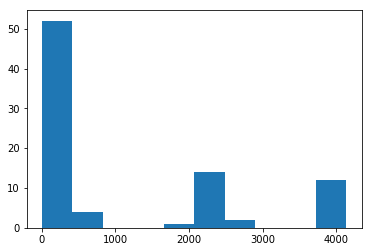

number of dimes: 66
number of pennies: 7
number of quarters: 12
Total value in image: $9.67


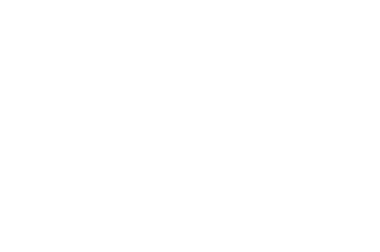

In [22]:
properties = measure.regionprops(labelled_coins)

coin_areas = np.array([prop.area for prop in properties])

print (coin_areas)

plt.figure()
plt.hist(coin_areas, bins=10)
plt.show()
plt.axis('off')

#print num_each_coin
num_dimes = len(np.where(coin_areas < 2300)[0])
num_pennies = len(np.where( (2300 < coin_areas) & (coin_areas < 3500))[0])
num_quarters = len(np.where(coin_areas > 3500)[0])

print ('number of dimes: %i' % num_dimes)
print ('number of pennies: %i' % num_pennies)
print ('number of quarters: %i' % num_quarters)
print ('Total value in image: $%.2f' % (num_dimes*.10 + num_pennies*.01 + num_quarters*.25))